In [73]:
"""
Author: Zaw
Findin the three most deviations of Predicting the LogP of molecules by using MLP
"""
import numpy as np
import pandas as pd
import math
import time
import os
import sys
import warnings
warnings.simplefilter(action='ignore')
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from hyperopt import fmin,tpe,hp,STATUS_OK, Trials
import pickle
start = time.time()

In [74]:
# Data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/LogP/data/extract_data.csv"
col_list=['LogP','Exp_RT']
lc_df = pd.read_csv(data_path,usecols=col_list)
col_smile_list=['SMILES','LogP','Exp_RT']
lc_smiles_df = pd.read_csv(data_path,usecols=col_smile_list)

# Remove non_retained molecules
# index=lc_df[lc_df['Exp_RT'] < 180].index
# lc_df.drop(lc_df[lc_df['Exp_RT'] < 180].index,inplace=True)

# Import descriptor file
path = os.getcwd()
dirname = os.path.dirname(path)
data_path = dirname+"/LogP/data/descriptors.csv"
des_df = pd.read_csv(data_path,index_col=0)

# Remove non_retained molecules
#des_df  = des_df.drop(des_df.index[[index]])
#lc_smiles_df = lc_smiles_df.drop(lc_smiles_df[[index]])
# combine two dataframe
data_comb = pd.concat([lc_smiles_df,des_df],axis=1)

In [75]:
data_comb

,SMILES,LogP,Exp_RT,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCSC(=N)N,0.67,93.5,6.635046,0.206019,6.635046,0.206019,0.378489,104.178,96.114,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@H](CN2C...,2.64,687.8,12.990628,-0.335181,12.990628,0.035905,0.760602,414.333,389.133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Oc1cccc2c(O)nccc12,1.73,583.6,9.356759,-0.052407,9.356759,0.052407,0.617197,161.160,154.104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NCCc1ccc(S(=O)(=O)F)cc1,1.05,653.1,12.386283,-4.565776,12.386283,0.311786,0.740582,203.238,193.158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CNC(=O)c1cc2c(cn1)[nH]c1ccccc12,1.33,705.6,11.531255,-0.169277,11.531255,0.169277,0.665746,225.251,214.163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2066,OCCn1cc(-c2ccc3c(c2)CC/C3=N\O)c(-c2ccncc2)n1,2.05,603.4,9.236427,0.039104,9.236427,0.039104,0.567510,334.379,316.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2067,CC(C)OC(=O)N1CCC(Oc2ncnc3c2cnn3-c2ccc(S(C)(=O)...,1.59,1061.4,14.683496,-3.539697,14.683496,0.054651,0.550748,477.518,453.326,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2068,CCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(=...,3.73,1059.3,12.960935,-1.190444,12.960935,0.073898,0.724147,402.531,368.259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2069,O=C(c1cc2ccccc2[nH]1)N1CCCC1,1.70,794.3,12.111258,0.133056,12.111258,0.133056,0.777073,214.268,200.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# # drop the smile column which can not be used for training
# data_comb = data_comb.drop(['SMILES'],axis=1)

# # Filling the nan with mean values in des_with_lc
# for col in data_comb:
#         data_comb[col].fillna(data_comb[col].mean(),inplace=True)
# # Remove features with low Variance(threshold <= 0.05)

# data_var = data_comb.var()
# del_feat = list(data_var[data_var <= 0.05].index)
# data_comb.drop(columns=del_feat, inplace=True)

# # Remove features with correlation(threshold >0.95)
# corr_matrix = data_comb.corr().abs()
# mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
# tri_df = corr_matrix.mask(mask)
# to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
# data = data_comb.drop(to_drop,axis=1)

In [77]:
# parameters
space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
          'gamma': hp.uniform('gamma', 0, 0.2),
          'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
          'subsample': hp.uniform('subsample', 0.7, 1.0),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
          'max_depth': hp.choice('max_depth', range(3, 10)),
          'n_estimators': hp.choice('n_estimators', [50, 100, 200, 300, 400, 500, 1000])}
min_child_weight_ls = range(1, 6)
max_depth_ls = range(3, 10)
n_estimators_ls = [100, 200, 300, 400, 500, 1000, 1500, 2000]

In [78]:
# The dataset with lc informations
#load the model with lc
path = os.getcwd()
dirname = os.path.dirname(path)

# load the model
file_path = dirname+"/logP/hyperparameters/xgb_lc.pkl"
best_parameters_with_lc = pickle.load(open(file_path,'rb'))

In [79]:
#Single random run with RT
data_set_1 = des_df
data_set_2 = lc_df
des_with_lc = pd.concat([data_set_1,data_set_2],axis=1)
des_with_lc_feat_corr = des_with_lc.columns[des_with_lc.corrwith(des_with_lc['LogP']) >=0.90][:-1]
des_with_lc = des_with_lc.drop(columns=des_with_lc_feat_corr)

# Rescale the feature
def scale(col):
    return (col - np.min(col))/(np.max(col)-np.min(col))

# Filling the nan with mean values in des_with_lc
for col in des_with_lc:
    des_with_lc[col].fillna(des_with_lc[col].mean(),inplace=True)

# Remove columns with zero vlues
des_with_lc = des_with_lc.loc[:,(des_with_lc**2).sum() != 0]
data = des_with_lc.drop(['LogP'],axis=1)

# Remove features with low Variance(threshold<=0.05)
data_var = data.var()
del_feat = list(data_var[data_var <= 0.05].index)
data.drop(columns=del_feat, inplace=True)

# Remove features with correlation(threshold > 0.95)
corr_matrix = data.corr().abs()
mask = np.triu(np.ones_like(corr_matrix,dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop =  [ c for c in tri_df.columns if any(tri_df[c] > 0.95)]
data = data.drop(to_drop,axis=1)

# Scale the features
cols = list(data)
data[cols] = data[cols].apply(scale,axis=0)
data = pd.concat([data,des_with_lc['LogP']],axis=1)

# Single random run

# data set preparation
train , test = train_test_split(data,train_size = 0.5,shuffle=True)
#validate , test = train_test_split(rest, train_size = 0.5, shuffle=True)

# training set
data_tra_x = train.drop(['LogP'],axis=1)
data_tra_y = train['LogP']

# # validation set
# data_val_x = validate.drop(['LogP'],axis=1)
# data_val_y = validate['LogP']

# test set
data_tes_x = test.drop(['LogP'],axis=1)
data_tes_y = test['LogP']

best_model = XGBRegressor( n_estimators=n_estimators_ls[best_parameters_with_lc['n_estimators']], 
                            max_depth=max_depth_ls[best_parameters_with_lc['max_depth']],
                            min_child_weight=min_child_weight_ls[best_parameters_with_lc['min_child_weight']],
                            learning_rate=best_parameters_with_lc['learning_rate'],
                            gamma=best_parameters_with_lc['gamma'],
                            subsample=best_parameters_with_lc['subsample'],
                            colsample_bytree=best_parameters_with_lc['colsample_bytree'],
                            n_jobs=6, random_state=1, seed=1)

best_model.fit(data_tra_x,data_tra_y)

# training error
tra_pred = best_model.predict(data_tra_x)
tra_results = ['tra',mean_squared_error(data_tra_y,tra_pred),
            mean_squared_error(data_tra_y,tra_pred,squared=False),
            mean_absolute_error(data_tra_y,tra_pred),
            r2_score(data_tra_y,tra_pred)]

# # validation error
# val_pred = best_model.predict(data_val_x)
# val_results = ['val',mean_squared_error(data_val_y,val_pred),
#             mean_squared_error(data_val_y,val_pred,squared=False),
#             mean_absolute_error(data_val_y,val_pred),
#             r2_score(data_val_y,val_pred)]
# testing error
tes_pred = best_model.predict(data_tes_x)
tes_results = ['tes',mean_squared_error(data_tes_y,tes_pred),
            mean_squared_error(data_tes_y,tes_pred,squared=False),
            mean_absolute_error(data_tes_y,tes_pred),
            r2_score(data_tes_y,tes_pred)]


all_set = tra_results,tes_results


all_set_df = pd.DataFrame(all_set,columns=['set','mse','rmse','mae','r2'])
print(all_set_df)
#all_set_df.to_excel(dirname+"/logP/results/mlp_single_rt.xlsx")
# print('\nSingle random run with LC information is done.')

# run_best_model(des_df,lc_df)

   set       mse      rmse       mae        r2
0  tra  0.013222  0.114988  0.088329  0.995119
1  tes  0.387123  0.622192  0.445825  0.870134


In [80]:
# Predictions
predictions = pd.DataFrame(tes_pred,columns=['Predicted LogP'])

data_test = test
data_test['index'] = data_test.index

data_comb_smiles = data_comb
data_comb_smiles['index'] = data_comb_smiles.index

result = pd.merge(data_test['index'],data_comb_smiles)

test_df = result[['SMILES','LogP']]

In [81]:
test_df

,SMILES,LogP
0,c1ccc(-c2nc(N3CCCCCC3)c3ccccc3n2)cc1,5.83
1,CN1CCC(OC(c2ccccc2)c2ccccc2)CC1,3.66
2,C=CC(C)(C)c1cc(/C=C/C(=O)c2ccc(O)cc2)c(OC)cc1O,4.81
3,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)O)c(C)c34)cc...,3.42
4,Cc1ccc2c(=O)c3cccc(CC(=O)O)c3oc2c1C,3.62
...,...,...
1031,Cn1cc(SCC(=O)N2CCCc3ccccc32)c2ccccc21,3.87
1032,Cc1nc2ccccc2nc1SCC(=O)c1ccccc1,3.57
1033,CC1=CC2=C(C=O)C(=O)[C@](C)(O)[C@@H](O)C2=CO1,-1.13
1034,C[N+]1(C)CCC(OC(=O)C(c2ccccc2)c2ccccc2)CC1,-0.70


In [82]:
# create dataframe with predicted LogP and Experimenatal logP
predictions = pd.DataFrame(tes_pred,columns=['Predicted LogP'])

xgb_df = pd.concat([test_df,predictions],axis=1)

xgb_df.rename(columns={'LogP':'Experimental LogP'},inplace=True)

xgb_df['Predicted LogP'] = xgb_df['Predicted LogP'].round(decimals=2)


In [83]:
xgb_df

,SMILES,Experimental LogP,Predicted LogP
0,c1ccc(-c2nc(N3CCCCCC3)c3ccccc3n2)cc1,5.83,4.96
1,CN1CCC(OC(c2ccccc2)c2ccccc2)CC1,3.66,4.13
2,C=CC(C)(C)c1cc(/C=C/C(=O)c2ccc(O)cc2)c(OC)cc1O,4.81,3.74
3,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)O)c(C)c34)cc...,3.42,3.34
4,Cc1ccc2c(=O)c3cccc(CC(=O)O)c3oc2c1C,3.62,2.90
...,...,...,...
1031,Cn1cc(SCC(=O)N2CCCc3ccccc32)c2ccccc21,3.87,4.19
1032,Cc1nc2ccccc2nc1SCC(=O)c1ccccc1,3.57,4.60
1033,CC1=CC2=C(C=O)C(=O)[C@](C)(O)[C@@H](O)C2=CO1,-1.13,-0.46
1034,C[N+]1(C)CCC(OC(=O)C(c2ccccc2)c2ccccc2)CC1,-0.70,1.99


In [84]:
# dataframe to csv
xgb_df.to_csv('xgb_exp_pre.csv')

In [85]:
# Find deviation
xgb_df['Deviation'] = (xgb_df['Experimental LogP']- xgb_df['Predicted LogP'])

In [86]:
# round off decimal value
xgb_df['Deviation'] = xgb_df['Deviation'].round(decimals=2)

In [87]:
xgb_df

,SMILES,Experimental LogP,Predicted LogP,Deviation
0,c1ccc(-c2nc(N3CCCCCC3)c3ccccc3n2)cc1,5.83,4.96,0.87
1,CN1CCC(OC(c2ccccc2)c2ccccc2)CC1,3.66,4.13,-0.47
2,C=CC(C)(C)c1cc(/C=C/C(=O)c2ccc(O)cc2)c(OC)cc1O,4.81,3.74,1.07
3,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)O)c(C)c34)cc...,3.42,3.34,0.08
4,Cc1ccc2c(=O)c3cccc(CC(=O)O)c3oc2c1C,3.62,2.90,0.72
...,...,...,...,...
1031,Cn1cc(SCC(=O)N2CCCc3ccccc32)c2ccccc21,3.87,4.19,-0.32
1032,Cc1nc2ccccc2nc1SCC(=O)c1ccccc1,3.57,4.60,-1.03
1033,CC1=CC2=C(C=O)C(=O)[C@](C)(O)[C@@H](O)C2=CO1,-1.13,-0.46,-0.67
1034,C[N+]1(C)CCC(OC(=O)C(c2ccccc2)c2ccccc2)CC1,-0.70,1.99,-2.69


In [88]:
# dataframe to csv
xgb_df.to_csv('xgb_exp_pre.csv')

In [89]:
# The three most deviation values
xgb_df.iloc[list(xgb_df['Deviation'].nlargest(3).index)]

,SMILES,Experimental LogP,Predicted LogP,Deviation
819,Cc1nc(N2CCN(c3ccccn3)CC2)c2c(C)c(C(=O)Nc3ccc(F...,5.84,3.74,2.10
538,CCCCCC(=O)C(=O)c1ccc(O)cc1O,3.90,1.82,2.08
728,CN(CO)c1nc(N(C)CO)nc(N(C)CO)n1,0.48,-1.50,1.98


In [90]:
xgb_df[xgb_df['Deviation']==2.10]['SMILES'].item()

'Cc1nc(N2CCN(c3ccccn3)CC2)c2c(C)c(C(=O)Nc3ccc(F)cc3F)sc2n1'

In [91]:
import pubchempy

smiles ='Cc1nc(N2CCN(c3ccccn3)CC2)c2c(C)c(C(=O)Nc3ccc(F)cc3F)sc2n1'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

N-(2,4-difluorophenyl)-2,5-dimethyl-4-(4-pyridin-2-ylpiperazin-1-yl)thieno[2,3-d]pyrimidine-6-carboxamide


In [92]:
smiles ='CCCCCC(=O)C(=O)c1ccc(O)cc1O'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

1-(2,4-dihydroxyphenyl)heptane-1,2-dione


In [93]:
smiles ='CN(CO)c1nc(N(C)CO)nc(N(C)CO)n1'
compounds = pubchempy.get_compounds(smiles, namespace='smiles')
match = compounds[0]
print(match.iupac_name)

[[4,6-bis[hydroxymethyl(methyl)amino]-1,3,5-triazin-2-yl]-methylamino]methanol


#### Display molecules

In [94]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg
import io

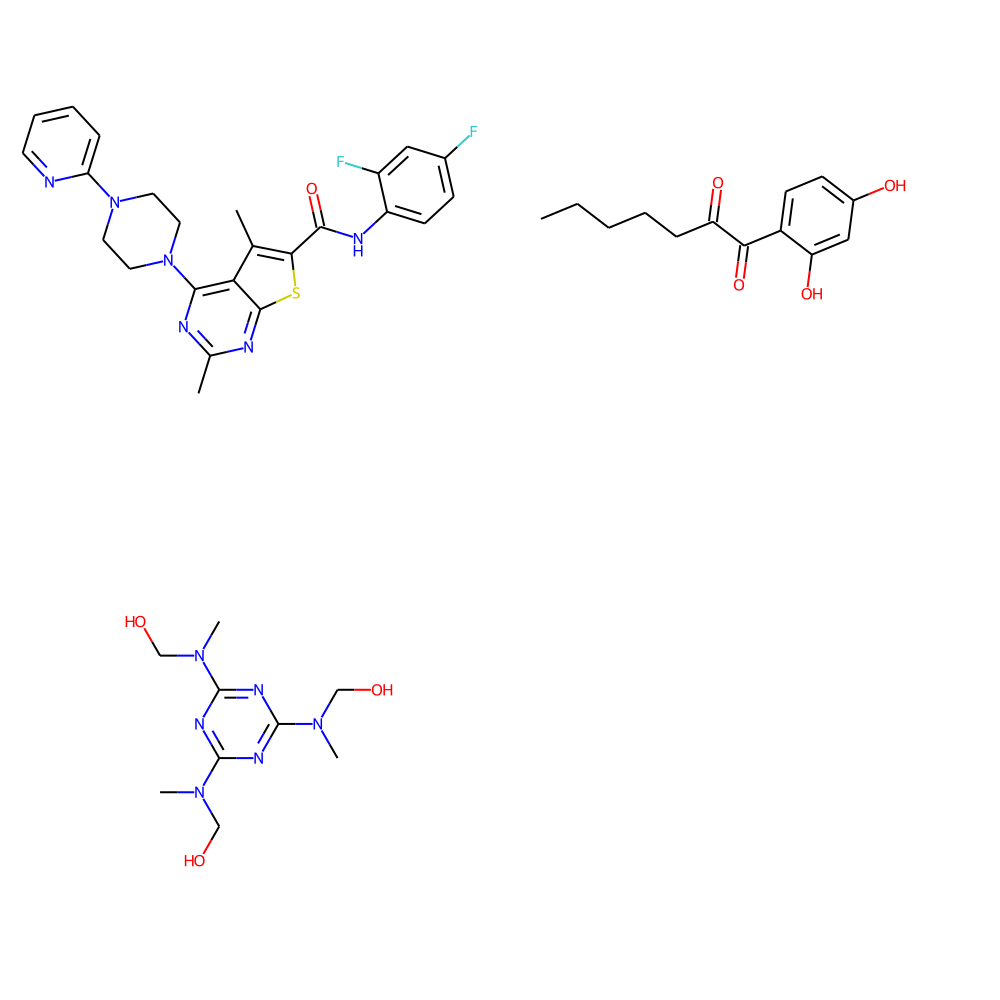

In [101]:
smiles = [
    'Cc1nc(N2CCN(c3ccccn3)CC2)c2c(C)c(C(=O)Nc3ccc(F)cc3F)sc2n1',
    'CCCCCC(=O)C(=O)c1ccc(O)cc1O',
    'CN(CO)c1nc(N(C)CO)nc(N(C)CO)n1'
    
]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(500, 500))

#### Smallest deviation

In [102]:
# The three most deviation values
xgb_df.iloc[list(xgb_df['Deviation'].nsmallest(3).index)]

,SMILES,Experimental LogP,Predicted LogP,Deviation
43,O=C1c2ccccc2C(=O)C1c1ccccn1,-2.59,1.60,-4.19
584,CC(n1cc(C[C@H](N)C(=O)O)c2ccccc21)n1cc(C[C@H](...,-1.56,1.49,-3.05
38,N[C@@]1(C(=O)O)CN[C@@H](C(=O)O)C1,-6.36,-3.37,-2.99


In [104]:
xgb_df[xgb_df['Deviation']==-3.05]['SMILES'].item()

'CC(n1cc(C[C@H](N)C(=O)O)c2ccccc21)n1cc(C[C@H](N)C(=O)O)c2ccccc21'

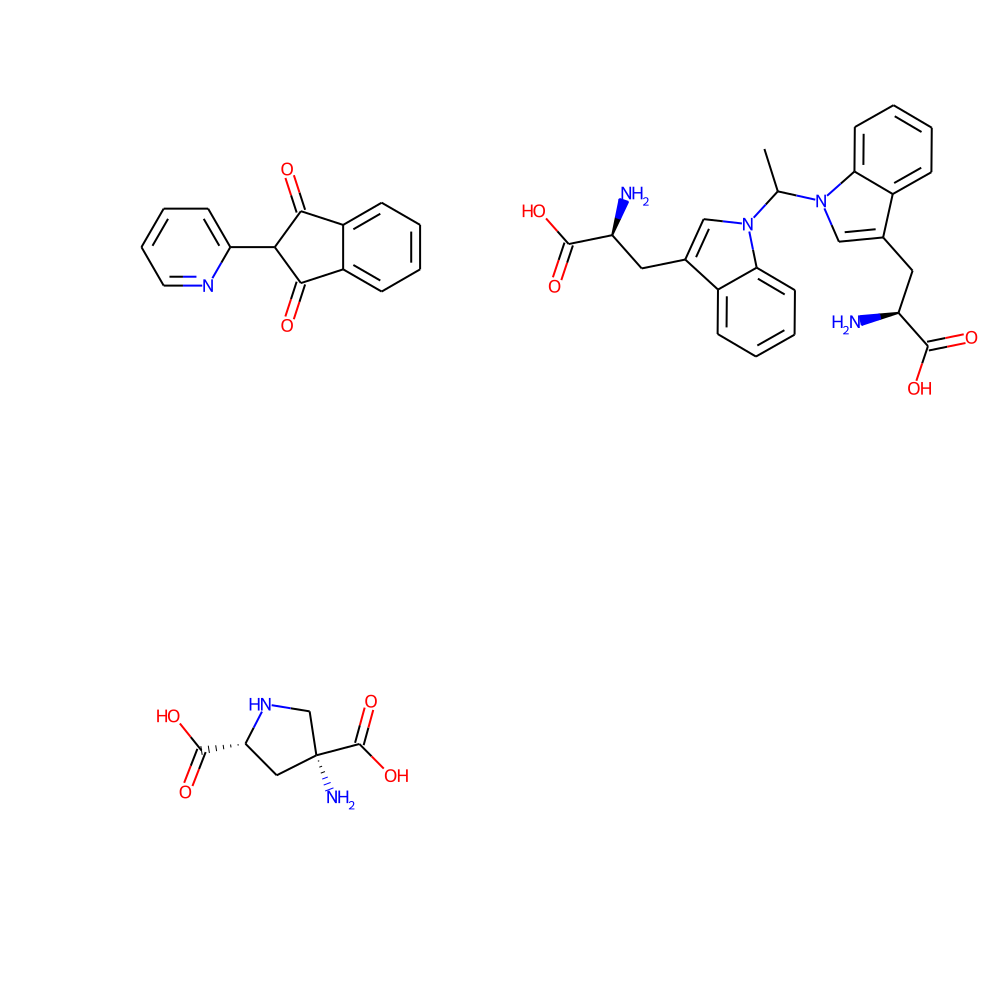

In [105]:
smiles = [
    'O=C1c2ccccc2C(=O)C1c1ccccn1',
    'CC(n1cc(C[C@H](N)C(=O)O)c2ccccc21)n1cc(C[C@H](N)C(=O)O)c2ccccc21',
    'N[C@@]1(C(=O)O)CN[C@@H](C(=O)O)C1'

]

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(500, 500))

In [106]:
xgb_df[xgb_df['Deviation']==-3.05]['SMILES'].item()

'CC(n1cc(C[C@H](N)C(=O)O)c2ccccc21)n1cc(C[C@H](N)C(=O)O)c2ccccc21'